In [5]:
from kneed import DataGenerator, KneeLocator
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import scipy.io
import json
import numpy as np
from format_data import *
from utils import *
import pickle
from utils_tt import *

In [2]:
t_pre = 0.2#0.2
t_post = 0.50#0.300
bin_width = 0.005
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)
#gc = np.arange(0, 32)

In [3]:
path = '/auto/data2/eTheremin/ALTAI/ALTAI_20240823_SESSION_01/'

In [4]:
tt_path = path+'headstage_0/tt.pkl'
with open(tt_path, 'rb') as file:
    tt = pickle.load(file)

In [6]:
triggers_tr, tones_total_tr = get_triggers(path+'headstage_0/', analog_line=0)
triggers_mc, tones_total_mc = get_triggers(path+'headstage_0/', analog_line=1)

In [14]:
condition_tr = np.zeros(len(triggers_tr))
condition_mc = np.full_like(triggers_mc, 2)

In [15]:
trig_times = np.concatenate((triggers_tr, triggers_mc))
tones = np.concatenate((tones_total_tr, tones_total_mc))
condition = np.concatenate((condition_tr, condition_mc)) 

In [19]:
sorted_indices = np.argsort(trig_times[:len(tones)])

In [20]:
len(sorted_indices)

6397

In [21]:
sorted_indices = sorted_indices[:-1]
sorted_triggers = trig_times[sorted_indices]
sorted_tones = tones[sorted_indices]
sorted_condition = condition[sorted_indices]

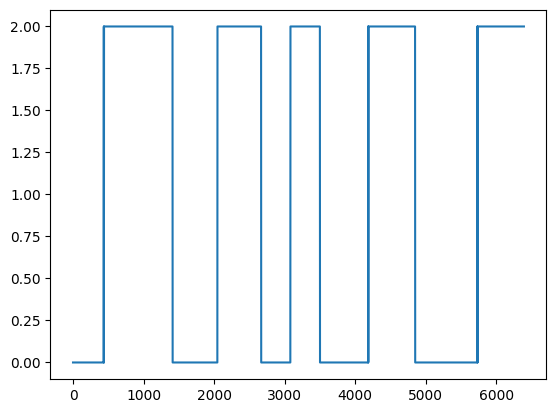

In [35]:
plt.plot(sorted_condition)

In [52]:
def creer_tableau_blocs(A):
    # Initialiser un tableau pour stocker les numéros de blocs
    blocs = np.zeros_like(A, dtype=int)  # Un tableau de la même taille que A, rempli de zéros
    bloc_courant = 0  # Compteur du bloc

    # Parcourir le tableau A
    for i in range(1, len(A)):
        # Si on trouve un 0, on démarre un nouveau bloc
        if A[i] == 0:
            bloc_courant += 1  # Nouveau bloc trouvé

        # Affecter le numéro du bloc courant
        blocs[i] = bloc_courant
    
    return blocs

In [53]:
block = creer_tableau_blocs(sorted_condition)

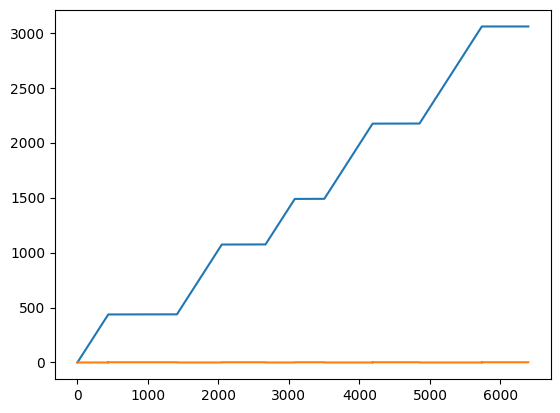

In [54]:
plt.plot(block)
plt.plot(sorted_condition)

In [27]:
json_path = find_json(path)
extracted_data = read_json_file(json_path)
tones, labels, mock_tones = concatenate_tones_and_labels(extracted_data, path+'headstage_0/tones')
condition, block = convert_condition_block(tones, labels)

In [29]:
extracted_data

[{'Block': 'Block_000',
  'Playback Mock_fn': None,
  'Playback Tones_fn': None,
  'Tracking Tones_fn': 'tones_tracking_00_ALTAI_SESSION_01_20240823.bin',
  'Mapping Change Tones_fn': 'tones_mc_00_ALTAI_SESSION_01_20240823.bin'},
 {'Block': 'Block_001',
  'Playback Mock_fn': None,
  'Playback Tones_fn': None,
  'Tracking Tones_fn': 'tones_tracking_01_ALTAI_SESSION_01_20240823.bin',
  'Mapping Change Tones_fn': 'tones_mc_00_ALTAI_SESSION_01_20240823.bin'},
 {'Block': 'Block_002',
  'Playback Mock_fn': None,
  'Playback Tones_fn': None,
  'Tracking Tones_fn': 'tones_tracking_02_ALTAI_SESSION_01_20240823.bin',
  'Mapping Change Tones_fn': 'tones_mc_00_ALTAI_SESSION_01_20240823.bin'},
 {'Block': 'Block_003',
  'Playback Mock_fn': None,
  'Playback Tones_fn': None,
  'Tracking Tones_fn': 'tones_tracking_03_ALTAI_SESSION_01_20240823.bin',
  'Mapping Change Tones_fn': 'tones_mc_00_ALTAI_SESSION_01_20240823.bin'},
 {'Block': 'Block_004',
  'Playback Mock_fn': None,
  'Playback Tones_fn': None,